<a href="https://colab.research.google.com/github/Minatozaki0911/CV202/blob/main/CV202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install keras

In [36]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold

from PIL import Image
from PIL import ImageFile

In [37]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/leapGestRecog/'
model_path = '/content/drive/MyDrive/Colab Notebooks/CV202_Model'

In [38]:
### Encode image label from image name
labels = dict()
count = 1
subdir = sorted(os.listdir(os.path.join(dataset_path, str("01/"))))
for i in subdir:
  labels[i] = count
  count += 1
print(labels)

{'01_palm': 1, '02_l': 2, '03_fist': 3, '04_fist_moved': 4, '05_thumb': 5, '06_index': 6, '07_ok': 7, '08_palm_moved': 8, '09_c': 9, '10_down': 10}


In [39]:
x_data = []
y_data = []
datacount = 0 
for i in range(1,3):
  print(i)
  for subdir in os.listdir(os.path.join(dataset_path, str("0"+str(i)+"/"))):
    count = 0
    print(subdir)
    for k in os.listdir(dataset_path + "0" + str(i) + "/" + subdir + "/" ):
      print(k)
      image = cv2.imread(dataset_path + "0" + str(i) + "/" + subdir + "/" + k, cv2.IMREAD_GRAYSCALE) # L = Luminance + grayscale
      image = cv2.resize(image, (320,120))
      arr = np.array(image)

      x_data.append(arr)
      count += 1    # Number of image in dataset
    y_label = np.full(shape=(count, 1), fill_value=labels[subdir])
    y_data.append(y_label)
    datacount += count

x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1)
print(datacount)
print(x_data.shape, y_data.shape)


1
04_fist_moved
frame_01_04_0004.png
frame_01_04_0006.png
frame_01_04_0008.png
frame_01_04_0016.png
frame_01_04_0001.png
frame_01_04_0012.png
frame_01_04_0010.png
frame_01_04_0009.png
frame_01_04_0015.png
frame_01_04_0013.png
frame_01_04_0017.png
frame_01_04_0011.png
frame_01_04_0005.png
frame_01_04_0003.png
frame_01_04_0021.png
frame_01_04_0007.png
frame_01_04_0019.png
frame_01_04_0020.png
frame_01_04_0014.png
frame_01_04_0002.png
frame_01_04_0018.png
frame_01_04_0053.png
frame_01_04_0054.png
frame_01_04_0155.png
frame_01_04_0178.png
frame_01_04_0153.png
frame_01_04_0154.png
frame_01_04_0082.png
frame_01_04_0071.png
frame_01_04_0106.png
frame_01_04_0183.png
frame_01_04_0200.png
frame_01_04_0109.png
frame_01_04_0125.png
frame_01_04_0103.png
frame_01_04_0147.png
frame_01_04_0070.png
frame_01_04_0073.png
frame_01_04_0122.png
frame_01_04_0051.png
frame_01_04_0084.png
frame_01_04_0140.png
frame_01_04_0092.png
frame_01_04_0096.png
frame_01_04_0027.png
frame_01_04_0128.png
frame_01_04_0173.p

In [40]:
x_data = np.expand_dims(x_data, axis=-1)    # expand dimension to fit 4D tensor format
x_data /= 255
print(x_data.shape)
y_data = to_categorical(y_data)  # one hot encoding
print(y_data.shape)

(4000, 120, 320, 1)
(4000, 11)


In [41]:
### Making Train - Validate - Test dataset with ratio 8-1-1
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5)
print(x_train.shape, x_valid.shape, x_test.shape)

(3200, 120, 320, 1) (400, 120, 320, 1) (400, 120, 320, 1)


In [52]:
input = Input(shape =(x_train.shape[1:]))

# 1st Conv Block
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 2nd Conv Block
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 3rd Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 4th Conv block
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 5th Conv block
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)
output = Dense(units = 11, activation ='softmax')(x)

In [53]:
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 120, 320, 1)]     0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 120, 320, 64)      640       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 120, 320, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 60, 160, 64)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 60, 160, 128)      73856     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 60, 160, 128)      147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 80, 128)       0   

In [54]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.9, staircase=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [55]:
model_checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [57]:
history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
50/50 [==============================] - 51s 850ms/step - loss: 0.0200 - acc: 0.9969 - val_loss: 7.5481e-04 - val_acc: 1.0000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CV202_Model/assets
Epoch 2/20
50/50 [==============================] - 43s 854ms/step - loss: 0.0027 - acc: 0.9994 - val_loss: 2.8091e-04 - val_acc: 1.0000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CV202_Model/assets
Epoch 3/20
50/50 [==============================] - 43s 854ms/step - loss: 0.0025 - acc: 0.9994 - val_loss: 8.8555e-05 - val_acc: 1.0000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CV202_Model/assets
Epoch 4/20
50/50 [==============================] - 43s 856ms/step - loss: 5.3131e-05 - acc: 1.0000 - val_loss: 4.2618e-05 - val_acc: 1.0000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CV202_Model/assets
Epoch 5/20
50/50 [==============================] - 43s 854ms/step - loss: 1

In [59]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/CV202_Model')
model.save("CV202_Model")         #Model folder contain .pb file

INFO:tensorflow:Assets written to: CV202_Model/assets


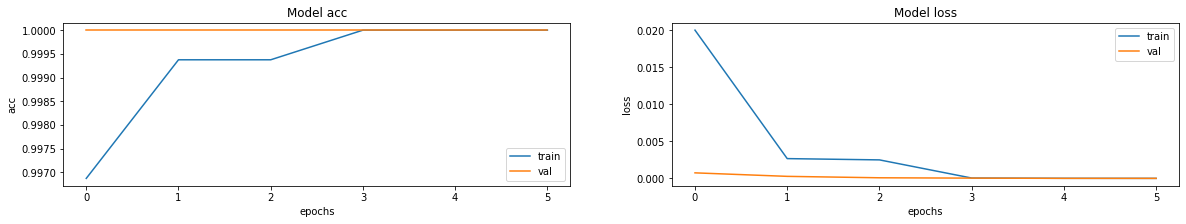

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [64]:
model.evaluate(x_valid, y_valid)
model.evaluate(x_test, y_test)

13/13 [==============================] - 2s 118ms/step - loss: 1.9790e-04 - acc: 1.0000


[0.00019790109945461154, 1.0]

In [112]:
predictions = model.predict(x_test) 
print(predictions.shape)
labels = list(labels)

(400, 11)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [115]:
y_test[0]
labels

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

Test data number 0
03_fist


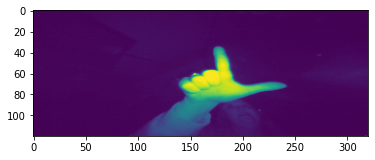

In [114]:
i=0

result = labels[np.argmax(predictions[i])]
print("Test data number "+str(i))
print(result)
plt.imshow(np.squeeze(x_test[i], axis=2))
plt.show()